In [1]:
import cv2 

# img = cv2.imread('/home/likcos/DataSets/sportimages/sportimages/basket/basket2_0001.jpg')
# print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [4]:
dirname = os.path.join(os.getcwd(),'D:\Descargas\Flores\Flores')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  D:\Descargas\Flores\Flores\
D:\Descargas\Flores\Flores\Crisantemos 1
D:\Descargas\Flores\Flores\Girasoles 255
D:\Descargas\Flores\Flores\Hortensia 319
D:\Descargas\Flores\Flores\Rosas\Rosas 270
D:\Descargas\Flores\Flores\Tulipanes 218
Directorios leidos: 5
Imagenes en cada directorio [256, 319, 270, 218, 254]
suma Total de imagenes en subdirs: 1317


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  1317


In [6]:
flores=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    flores.append(name[len(name)-1])
    indice=indice+1

0 Crisantemos
1 Girasoles
2 Hortensia
3 Rosas
4 Tulipanes


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (1053, 100, 100, 3) (1053,)
Testing data shape :  (264, 100, 100, 3) (264,)


Text(0.5, 1.0, 'Ground Truth : 1')

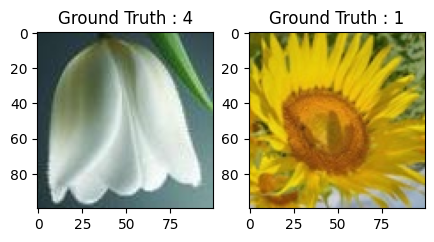

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

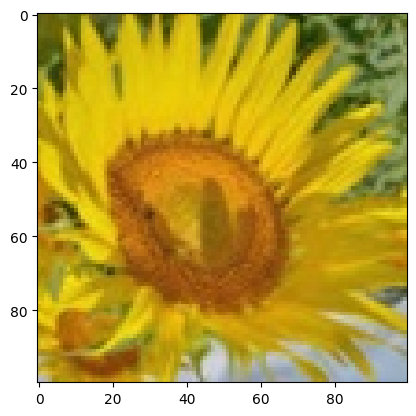

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [11]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(842, 100, 100, 3) (211, 100, 100, 3) (842, 5) (211, 5)


# Creamos el modelo de CNN

In [48]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 500 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 16 # cantidad de imágenes que se toman a la vez en memoria

In [49]:
flower_model = Sequential()
flower_model.add(Conv2D(16, kernel_size=(5, 5),activation='linear',padding='same',input_shape=(100,100,3)))
flower_model.add(LeakyReLU(alpha=0.1))
flower_model.add(MaxPooling2D((2, 2),padding='same'))
flower_model.add(Dropout(0.5))

flower_model.add(Flatten())
flower_model.add(Dense(32, activation='linear'))
flower_model.add(LeakyReLU(alpha=0.1))
flower_model.add(Dropout(0.5))
flower_model.add(Dense(nClasses, activation='softmax'))

In [50]:
flower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      1216      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1280032   
                                                      

In [51]:
flower_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [52]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
flower_train = flower_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/500
53/53 [==============================] - 3s 33ms/step - loss: 1.1793 - accuracy: 0.5273 - val_loss: 0.6525 - val_accuracy: 0.8531
Epoch 2/500
53/53 [==============================] - 1s 24ms/step - loss: 0.7034 - accuracy: 0.7435 - val_loss: 0.3701 - val_accuracy: 0.9905
Epoch 3/500
53/53 [==============================] - 1s 23ms/step - loss: 0.5106 - accuracy: 0.8492 - val_loss: 0.2269 - val_accuracy: 0.9953
Epoch 4/500
53/53 [==============================] - 1s 24ms/step - loss: 0.3921 - accuracy: 0.8943 - val_loss: 0.1668 - val_accuracy: 0.9953
Epoch 5/500
53/53 [==============================] - 1s 23ms/step - loss: 0.3422 - accuracy: 0.9121 - val_loss: 0.1222 - val_accuracy: 0.9953
Epoch 6/500
53/53 [==============================] - 1s 23ms/step - loss: 0.2779 - accuracy: 0.9335 - val_loss: 0.1021 - val_accuracy: 0.9953
Epoch 7/500
53/53 [==============================] - 1s 23ms/step - loss: 0.2548 - accuracy: 0.9406 - val_loss: 0.0865 - val_accuracy: 0.9953
Epoch 

In [73]:
flower_model.save(r"D:\Documentos\Tec\9° semestre\IA\IA-main\IA-main\test.h5py")


FailedPreconditionError: D:\Documentos\Tec\9° semestre\IA\IA-main\IA-main is not a directory

# Evaluamos la red

In [54]:
test_eval = flower_model.evaluate(test_X, test_Y_one_hot, verbose=1)

9/9 [==============================] - 0s 9ms/step - loss: 0.0364 - accuracy: 0.9962


In [55]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.036427125334739685
Test accuracy: 0.9962121248245239


In [56]:
flower_model.history

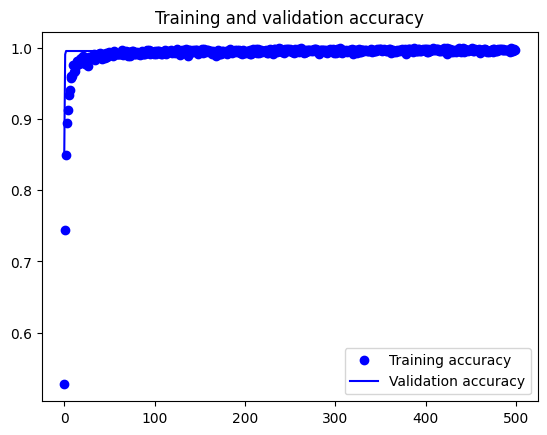

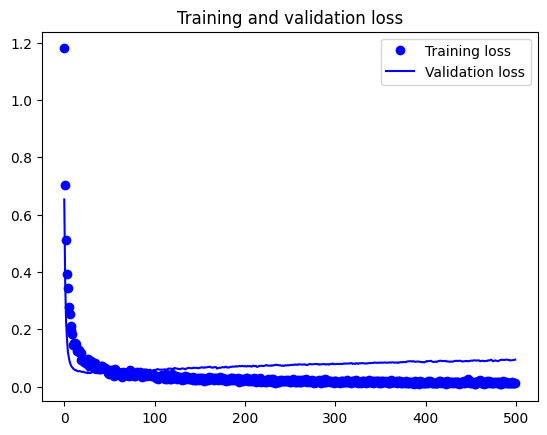

In [57]:
accuracy = flower_train.history['accuracy']
val_accuracy = flower_train.history['val_accuracy']
loss = flower_train.history['loss']
val_loss = flower_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [58]:
predicted_classes2 = flower_model.predict(test_X)

9/9 [==============================] - 0s 9ms/step


In [59]:
predicted_classes=[]
for predicted_flower in predicted_classes2:
    predicted_classes.append(predicted_flower.tolist().index(max(predicted_flower)))
predicted_classes=np.array(predicted_classes)

In [60]:
predicted_classes.shape, test_Y.shape

((264,), (264,))

# Aprendamos de los errores: Qué mejorar

Found 263 correct labels


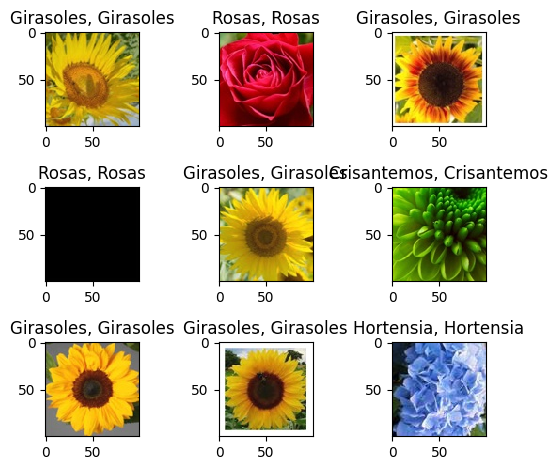

In [61]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[correct]],
                                                    flores[test_Y[correct]]))

    plt.tight_layout()

Found 1 incorrect labels


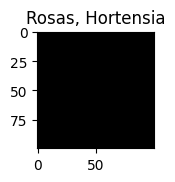

In [62]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[incorrect]],
                                                    flores[test_Y[incorrect]]))
    plt.tight_layout()

In [63]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        46
     Class 1       1.00      1.00      1.00        67
     Class 2       1.00      0.98      0.99        54
     Class 3       0.98      1.00      0.99        45
     Class 4       1.00      1.00      1.00        52

    accuracy                           1.00       264
   macro avg       1.00      1.00      1.00       264
weighted avg       1.00      1.00      1.00       264

